<a href="https://www.kaggle.com/code/anshv2/credit-card-approvin?scriptVersionId=116957563" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#importing stuff
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import optuna 
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

#fetching data
data = pd.read_csv('../input/credit-card-approval-prediction/application_record.csv')
values = pd.read_csv('../input/credit-card-approval-prediction/credit_record.csv')

#cleaning usless features
data = data.drop(columns=['FLAG_MOBIL'])
data.nunique()


ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

# Data Transformation

In [2]:
#Feature Engineering
data['CODE_GENDER'].replace(['F','M'], [0,1],inplace=True)
data['FLAG_OWN_CAR'].replace(['Y','N'], [1,0],inplace=True)
data['FLAG_OWN_REALTY'].replace(['Y','N'], [1,0],inplace=True)
data = pd.get_dummies(data, columns=
               ['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS'
               , 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'])
values = values[values.STATUS != 'X']

In [3]:
#creating true data set
td = pd.merge(data, values, on="ID")

#classification set:
td['STATUS'].replace(['C'], [1],inplace=True)
class_data = td
class_data.loc[class_data['STATUS'] != 1, 'STATUS'] = 0
print(class_data['STATUS'])

0         1
1         1
2         1
3         1
4         1
         ..
631760    0
631761    0
631762    0
631763    0
631764    0
Name: STATUS, Length: 631765, dtype: object


In [4]:
x_train, x_test, y_train, y_test = train_test_split(class_data.drop(columns = 'STATUS', axis =1), class_data['STATUS'].astype(int))

# Model Creation 

In [5]:
"""
def objective(trial):
    # Define the search space
    #n_estimators = trial.suggest_int('n_estimators', 100, 1000, 100)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    

    model = RandomForestClassifier(#n_estimators = n_estimators,
                                   max_features = max_features,
                                   min_samples_split = min_samples_split,
                                   min_samples_leaf = min_samples_leaf,
                                   n_jobs=-1)
    
    score = cross_val_score(model, x_train, y_train, scoring="accuracy").mean()

    return score

study = optuna.create_study(study_name="rf_optimization",
                            direction="maximize",
                            sampler=TPESampler())

study.optimize(objective, n_trials=10)
"""

'\ndef objective(trial):\n    # Define the search space\n    #n_estimators = trial.suggest_int(\'n_estimators\', 100, 1000, 100)\n    max_features = trial.suggest_categorical(\'max_features\', [\'auto\', \'sqrt\'])\n    min_samples_split = trial.suggest_categorical(\'min_samples_split\', [2, 5])\n    min_samples_leaf = trial.suggest_categorical(\'min_samples_leaf\', [1, 2])\n    \n\n    model = RandomForestClassifier(#n_estimators = n_estimators,\n                                   max_features = max_features,\n                                   min_samples_split = min_samples_split,\n                                   min_samples_leaf = min_samples_leaf,\n                                   n_jobs=-1)\n    \n    score = cross_val_score(model, x_train, y_train, scoring="accuracy").mean()\n\n    return score\n\nstudy = optuna.create_study(study_name="rf_optimization",\n                            direction="maximize",\n                            sampler=TPESampler())\n\nstudy.optimize(o

In [6]:
"""
print(study.best_value)
print(study.best_params)
"""

'\nprint(study.best_value)\nprint(study.best_params)\n'

In [7]:
 model = RandomForestClassifier(max_features = 'auto',
                                   min_samples_split = 2,
                                   min_samples_leaf = 1,
                                   n_jobs=-1)
    
model.fit(x_train, y_train)
model.score(x_test, y_test)
y_pred = model.predict(x_test)

# Model Evaluation

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     75761
           1       0.95      0.95      0.95     82181

    accuracy                           0.95    157942
   macro avg       0.95      0.95      0.95    157942
weighted avg       0.95      0.95      0.95    157942



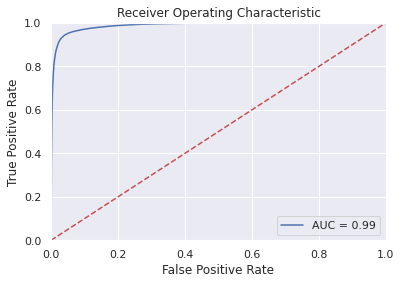

In [8]:
#Model_Evaluation

def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
print(classification_report(y_test, y_pred))
plot_roc_auc(y_test, model.predict_proba(x_test)[:,1])

# Deploying Model

In [9]:
import pickle
import bz2

ofile = bz2.BZ2File("Credit_model.pkl",'wb')
pickle.dump(model, ofile)
ofile.close()
 